In [1]:
import os
import numpy as np

# Audio Processing

In the following, we are going to show several topics about audio as well as signal processing.

Reference:
* https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
* http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
* http://mirlab.org/jang/books/audiosignalprocessing/speechFeatureMfcc_chinese.asp?title=12-2%20MFCC

In [2]:
!pip install --no-cache-dir -q numpy scipy matplotlib

In [3]:
# momo
# !wget -O /tmp/CantinaBand3.wav https://www2.cs.uic.edu/~i101/SoundFiles/CantinaBand3.wav

# stereo 16-bit data (speakers: FL FR)
!wget -O /tmp/M1F1-int16WE-AFsp.wav http://www-mmsp.ece.mcgill.ca/Documents/AudioFormats/WAVE/Samples/AFsp/M1F1-int16WE-AFsp.wav

--2021-11-30 06:08:21--  http://www-mmsp.ece.mcgill.ca/Documents/AudioFormats/WAVE/Samples/AFsp/M1F1-int16WE-AFsp.wav
Resolving www-mmsp.ece.mcgill.ca (www-mmsp.ece.mcgill.ca)... 132.206.75.13
Connecting to www-mmsp.ece.mcgill.ca (www-mmsp.ece.mcgill.ca)|132.206.75.13|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94226 (92K) [audio/x-wav]
Saving to: ‘/tmp/M1F1-int16WE-AFsp.wav’

/tmp/M1F1-int16WE-A 100%[===================>]  92.02K   512KB/s    in 0.2s    

2021-11-30 06:08:22 (512 KB/s) - ‘/tmp/M1F1-int16WE-AFsp.wav’ saved [94226/94226]



In [4]:
wav_file = "/tmp/M1F1-int16WE-AFsp.wav"
assert os.path.exists(wav_file)

## Amplitude Analyzing

To record the audio into file, there are two major considerations.

1. the sampling rate
2. the number of channels

Second, in addition to the above, when analyzing the audio file, there are two major components.

1. the frequency, it is correlated to the sampling rate
2. the amplitude


In [5]:
import scipy
from scipy.io.wavfile import read
import matplotlib.pyplot as plt

import tensorflow as tf
print("Tensorflow Version: {}".format(tf.__version__))

Tensorflow Version: 2.7.0


### Reading audio samples

In [6]:
audio_rate, audio_data = read(wav_file)

print("sample rate: {}".format(audio_rate))
print(audio_data.shape)  # (x, 2): 2 channels

sample rate: 8000
(23493, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """Entry point for launching an IPython kernel.


In [7]:
# fptr = tf.io.read_file(wav_file)
# _audio_data, _audio_rate = tf.audio.decode_wav(fptr)
# _audio_data, _audio_rate

### Showing the samples of the first 2 seconds

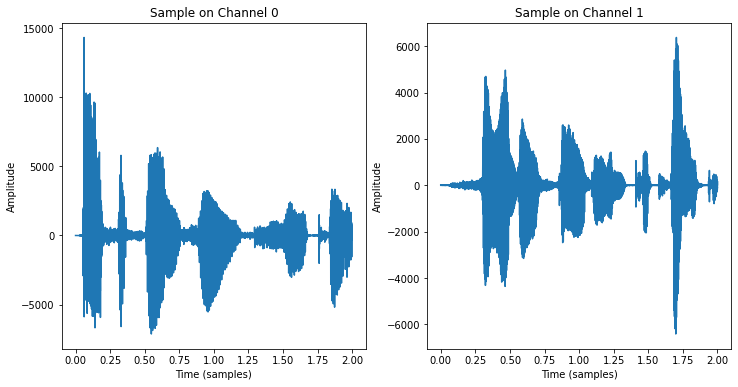

In [8]:
secs = 2
sample_size = audio_rate * secs
sec_range = np.linspace(0, secs, sample_size)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(sec_range, audio_data[0:sample_size, 0])
ax[0].set_ylabel("Amplitude")
ax[0].set_xlabel("Time (samples)")
ax[0].set_title("Sample on Channel 0")

ax[1].plot(sec_range, audio_data[0:sample_size, 1])
ax[1].set_ylabel("Amplitude")
ax[1].set_xlabel("Time (samples)")
ax[1].set_title("Sample on Channel 1")
plt.show()

## Pre-Emphasis

The first step is to emplify the high frequencies. There are several reasons why applying the pre-emphasis filter.

1. Balance the frequency specturm since the high frequencies usually have smaller magnitudes compared to the lower frequencies.
2. Avoid the numerical problems during the Fourier transform operations.
3. May also improve the signal-to-noise (SNR).

The following is the operation.

$$y(t) = x(t) - \alpha x(t-1)$$

where $\alpha$ is the filter coefficient and usually set to `0.97`.

In [9]:
channel_idx = 1
alpha = 0.97
_audio_content = audio_data[0:sample_size, channel_idx]
audio_content = _audio_content[1:] - alpha * _audio_content[:len(_audio_content)-1]
audio_content = np.concatenate([_audio_content[:1], audio_content])
audio_content.shape

(16000,)

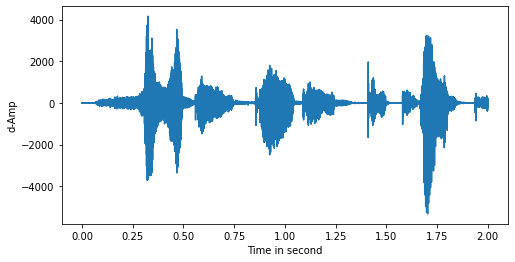

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(sec_range, audio_content)
ax.set_xlabel("Time in second")
ax.set_ylabel("d-Amp")
plt.show()

You can also achieve the pre-emphasis by using mean normalization.

## Framing

Next, we will split the signal into several parts by time. The rationale behind is that the frequencies would change over time so that it is not rational applying the Fourier transform to the whole signal. That causes the loss of frequency contours of the signal. On the contrast, after spliting the signal into pieces by time. We apply the Fourier transform to each pieces of signal, and conconcate the adjacent transformed information to approximate the frequencies over the whole signal.

Typical the frame size of audio recognition is 20-40 ms with 50% overlap between consecutive frames. The popular frame size is 25 ms (0.025 for 1 second) and the overlap is 10 ms (0.01 for 1 second).

The final framing result would be in the shape of `[num_frames, frame_length]`.

In [11]:
frame_size = 0.025
frame_stride = 0.01

frame_length = int(round(frame_size * audio_rate))
frame_step = int(round(frame_stride * audio_rate))
signal_length = len(audio_content)

num_frames = np.ceil((signal_length - frame_length) / frame_step).astype(np.int)

print("Frame length: {}".format(frame_length))
print("Frame Stride: {}".format(frame_step))
print("Number of frames: {}".format(num_frames))
print("Signal Length: {}".format(signal_length))

Frame length: 200
Frame Stride: 80
Number of frames: 198
Signal Length: 16000


In [12]:
pad_signal_length = num_frames * frame_step + frame_length
padded = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(audio_content, padded)

print("Padded signal length: {}".format(pad_signal_length))
print("Padded Signal: {}".format(pad_signal.shape))

Padded signal length: 16040
Padded Signal: (16040,)


In [13]:
indices = np.tile(np.arange(0, frame_length), (num_frames, 1))
indices += np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T

indices

array([[    0,     1,     2, ...,   197,   198,   199],
       [   80,    81,    82, ...,   277,   278,   279],
       [  160,   161,   162, ...,   357,   358,   359],
       ...,
       [15600, 15601, 15602, ..., 15797, 15798, 15799],
       [15680, 15681, 15682, ..., 15877, 15878, 15879],
       [15760, 15761, 15762, ..., 15957, 15958, 15959]])

In [14]:
frames = pad_signal[indices]
print("Frames' shapes: {}".format(frames.shape))

pad_signal[indices]

Frames' shapes: (198, 200)


array([[ 0.0000e+00,  0.0000e+00,  2.0000e+00, ..., -4.9700e+00,
         8.8000e-01,  6.9100e+00],
       [-5.0000e+00,  8.5000e-01,  7.8800e+00, ..., -2.9400e+00,
        -3.0000e-02, -3.0000e-02],
       [-6.9400e+00, -1.1500e+00,  5.8200e+00, ...,  2.0000e+00,
         1.0600e+00,  3.0900e+00],
       ...,
       [-5.6120e+01,  1.1110e+01, -7.5590e+01, ..., -1.8907e+02,
        -2.0613e+02, -2.4552e+02],
       [-5.6970e+01, -3.6770e+01, -1.9910e+01, ..., -5.1810e+01,
         1.9366e+02,  4.4540e+01],
       [-2.4044e+02, -3.9520e+01, -1.4236e+02, ..., -2.4240e+02,
         2.9522e+02, -5.1810e+01]])

In [15]:
pad_signal[-100:]

array([  16.74,  -40.72,  118.08,  -54.32,  -63.  ,  174.11,   95.39,
       -195.85,  -47.91,  111.65,  -31.96,  180.02,  174.39, -260.57,
        -98.73,  341.21, -217.56, -242.4 ,  295.22,  -51.81,   15.48,
       -114.16, -113.7 ,  231.88,  -87.07, -218.8 ,  128.6 ,  167.62,
        -15.31, -282.88,   -2.46,   45.63,  126.16,  208.06, -395.7 ,
        119.24, -101.01, -125.98,  184.39,  -61.82,  225.41,   57.31,
       -174.04, -172.38,  225.49,  187.45, -243.94,  -46.44,  -16.79,
        193.79,  102.7 , -366.3 ,  103.54,  -29.19,  228.  ,   26.93,
       -101.38,  128.44,  -87.75,  -57.54,    0.  ,    0.  ,    0.  ,
          0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
          0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
          0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
          0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
          0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
          0.  ,    0

## Applying a window

In [16]:
from scipy.signal import hann
from scipy.fftpack import rfft

* Famous Window Function:

https://zh.wikipedia.org/wiki/%E7%AA%97%E5%87%BD%E6%95%B0#Hamming%E7%AA%97%E8%88%87Hann%E7%AA%97


* Window Function:

$$w(n) = \alpha - (1 - \alpha) \cos\left(\frac{2\pi{n}}{N-1}\right)
\qquad 0 \leq n \leq N-1$$

If $\alpha$ is 0.53836, the window is called `hamming` window, and if $\alpha$ is 0.5, the window is called `hann` window.


In the signal processing, the window function is applied to filter the signal. It is just like inspect the signal via the window. The assumption of applying the window function is made by FFT that the data is infinite and to reduce the spectral leakage.

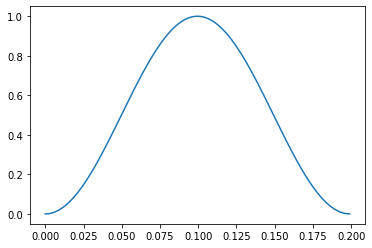

(200,)

In [17]:
window = hann(frame_length)

plt.plot(np.arange(frame_length)/1000, window)
plt.show()

window.shape

Now we will apply the window function to each frame.

In [18]:
frames.shape, window.reshape(1, -1).shape

((198, 200), (1, 200))

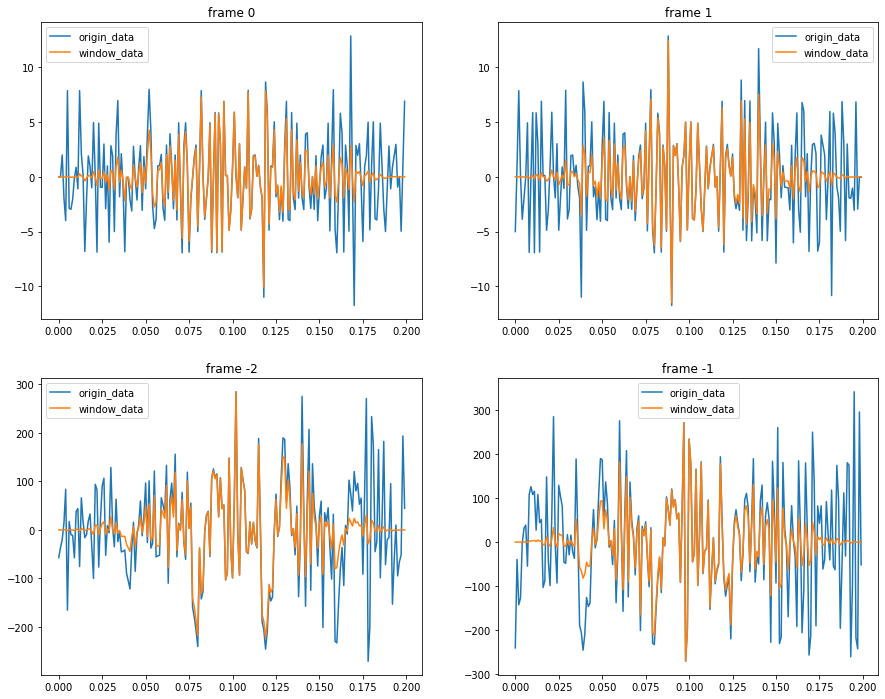

In [19]:
window_frames = frames * window.reshape(1, -1)

# to microseconds
msecs = np.arange(len(window)) / 1000

fig, ax = plt.subplots(2, 2, figsize=(15, 12))
ax[0][0].plot(msecs, frames[0])
ax[0][0].plot(msecs, window_frames[0])
ax[0][0].set_title("frame 0")
ax[0][0].legend(["origin_data", "window_data"])
ax[0][1].plot(msecs, frames[1])
ax[0][1].plot(msecs, window_frames[1])
ax[0][1].set_title("frame 1")
ax[0][1].legend(["origin_data", "window_data"])
ax[1][0].plot(msecs, frames[-2])
ax[1][0].plot(msecs, window_frames[-2])
ax[1][0].set_title("frame -2")
ax[1][0].legend(["origin_data", "window_data"])
ax[1][1].plot(msecs, frames[-1])
ax[1][1].plot(msecs, window_frames[-1])
ax[1][1].set_title("frame -1")
ax[1][1].legend(["origin_data", "window_data"])
plt.show()

## Applying a FFT

This function computes the one-dimensional n-point discrete Fourier Transform (DFT) of a real-valued array by means of the Fast Fourier Transform (FFT).

In scipy:

$$y(j) = \sum_{k=0..n-1} x_k * exp^{\frac{-sqrt(-1)jk2\pi}{n}}$$
where $j = 0..n-1$

$[y(0),Re(y(1)),Im(y(1)),...,Re(y(n/2))]$              if n is even

$[y(0),Re(y(1)),Im(y(1)),...,Re(y(n/2)),Im(y(n/2))]$   if n is odd

In the following, we are going to apply FFT via scipy.fftpack.rfft. The `rfft` applies FFT to a real sequence. You can also use similiar functions from other packages, like numpy.fft.fft.


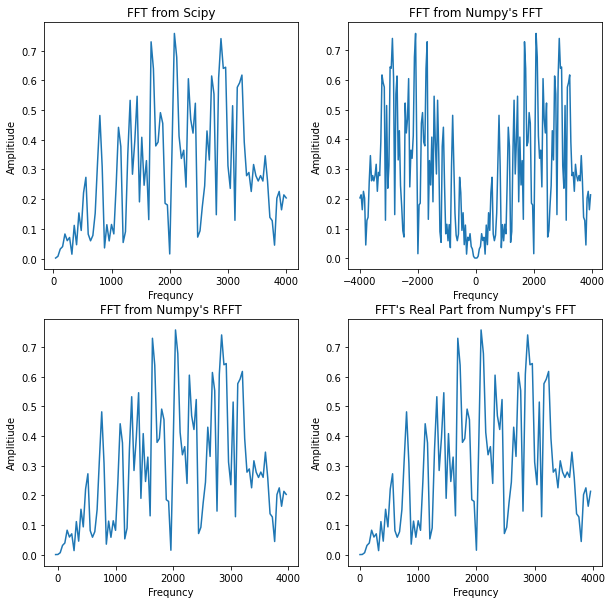

In [20]:
frame_idx = 0
window_audio = window_frames[frame_idx]

# scipy version
# abs() to get the length of the complex value from fft
amp_scipy = abs(rfft(window_audio))
amp_scipy_real = np.array(amp_scipy[1::2].tolist())
if len(amp_scipy) % 2 == 0:
  amp_scipy_img = np.array(amp_scipy[2::2].tolist() + [0j])
amp_scipy = amp_scipy_real + 1j*amp_scipy_img
amp_scipy = [amp_scipy[0]] + amp_scipy
amp_scipy = abs(amp_scipy)
amp_scipy /= (len(window_audio) / 2)

# d is the scaling factor, is equal to 1/sample_date = peroid
freq_scipy = scipy.fftpack.rfftfreq(n=len(window_audio), d=1/audio_rate)
freq_scipy = [freq_scipy[0]] + np.array(freq_scipy[1::2].tolist())

# numpy version from FFT
amp_numpy = abs(np.fft.fft(window_audio))
# [0, ts] to [-ts/2, -ts/2]
amp_numpy = np.fft.fftshift(amp_numpy)
amp_numpy /= (len(window_audio) / 2)

freq_numpy = np.fft.fftfreq(len(window_audio))
freq_numpy = np.fft.fftshift(freq_numpy)
freq_numpy *= audio_rate

half_idx = int(len(freq_numpy) / 2)

# numpy version from FFT RFFT
amp_numpy_rfft = abs(np.fft.rfft(window_audio))
amp_numpy_rfft /= (len(window_audio) / 2)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].plot(freq_scipy, amp_scipy)
ax[0][0].set_xlabel("Frequncy")
ax[0][0].set_ylabel("Amplitiude")
ax[0][0].set_title("FFT from Scipy")

ax[1][0].plot(freq_numpy[half_idx-1:], amp_numpy_rfft)
ax[1][0].set_xlabel("Frequncy")
ax[1][0].set_ylabel("Amplitiude")
ax[1][0].set_title("FFT from Numpy's RFFT")

ax[0][1].plot(freq_numpy, amp_numpy)
ax[0][1].set_xlabel("Frequncy")
ax[0][1].set_ylabel("Amplitiude")
ax[0][1].set_title("FFT from Numpy's FFT")

ax[1][1].plot(freq_numpy[half_idx:], amp_numpy[half_idx:])
ax[1][1].set_xlabel("Frequncy")
ax[1][1].set_ylabel("Amplitiude")
ax[1][1].set_title("FFT's Real Part from Numpy's FFT")
plt.show()

It is obvious that different FFT results got from different packages. The following is the simple example.

In [21]:
signals = np.array([1,2,3,4,5,6,7])
np_rfft = np.fft.rfft(signals).real
sp_rfft = scipy.fftpack.rfft(signals)
sp_rfft = [sp_rfft[0]] + sp_rfft[1::2].tolist()

print(np_rfft)
print(sp_rfft)

[28.  -3.5 -3.5 -3.5]
[28.0, -3.5000000000000018, -3.500000000000001, -3.5000000000000013]


### Converting to DB (Magnitude)

In the above spectrum (amplitude vs frequency), it shows the converting relation between the amplitude and frequency. However, the spectrum can be further processed by log functions to reveal those frequency components with lower ampltitudes. Such the specturm of transfromation to the log scale is called the log specturm. Its y-axis is the unit of the level of energy, that is DB. Such specturm of scaling is also called DB-scaled specturm.

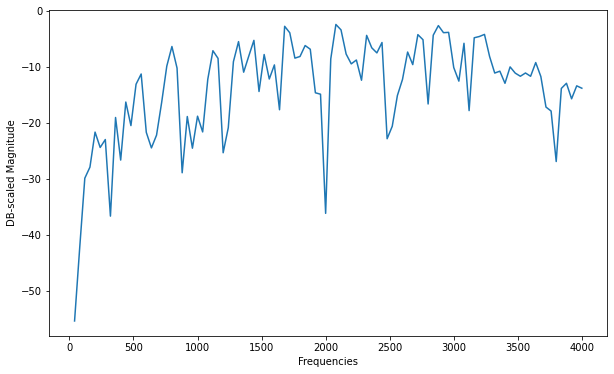

In [22]:
mags = 20 * np.log10(amp_scipy)

plt.figure(figsize=(10, 6))
plt.plot(freq_scipy, mags)
plt.ylabel("DB-scaled Magnitude")
plt.xlabel("Frequencies")
plt.show()

## Short time fourier transform and Power Spectrum

To fourier transform, the transform of signal to the frequency domain loses the time information. The above section shows the theory of how FFT works. In practice, it is more common to transform the signal via short-time fourier transform (`STFT`) in order to keep the time information.

### Theoretical STFT

In [23]:
nFFT = 512
# calculate the frequency spectrum
mag_frames = np.abs(np.fft.rfft(window_frames, nFFT))

# 257 = int(512 / 2) + 1
mag_frames.shape

(198, 257)

### Scipy's STFT

You can simply use `scipy.signal.stft` to split the original audio by sampling points (equal to time) and the number of overlapping.

In [24]:
stft_freq, stft_time, stft = scipy.signal.stft(
  x=audio_content, 
  fs=1.0,
  window='hann',
  nperseg=frame_length,
  noverlap=frame_length-frame_step,  
  nfft=nFFT, 
  padded=True)

# 257 = int(512 / 2) + 1
stft_freq.shape, stft_time.shape, stft.shape

((257,), (201,), (257, 201))

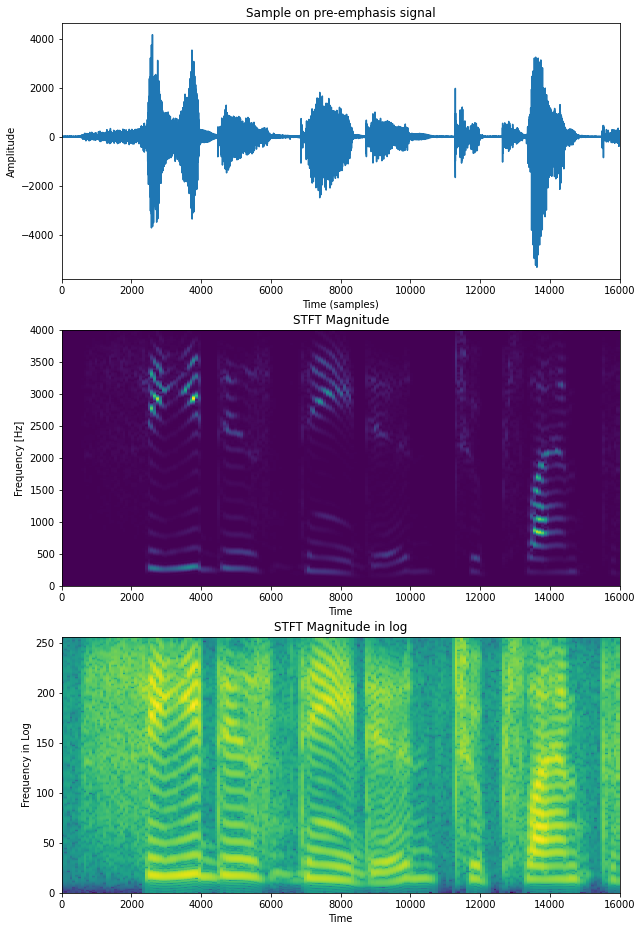

(257, 201)

In [25]:
mag_scipy_stft = np.abs(stft)
mag_scipy_stft_log = np.log(mag_scipy_stft + np.finfo(float).eps)

fig, ax = plt.subplots(3, 1, figsize=(10, 16))
ax[0].plot(audio_content)
ax[0].set_ylabel("Amplitude")
ax[0].set_xlabel("Time (samples)")
ax[0].set_title("Sample on pre-emphasis signal")
ax[0].set_xlim((0, 16000))

ax[1].pcolormesh(stft_time, stft_freq * audio_rate, mag_scipy_stft)
ax[1].set_title('STFT Magnitude')
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Frequency [Hz]")

ax[2].pcolormesh(stft_time, range(mag_scipy_stft_log.shape[0]), mag_scipy_stft_log)
ax[2].set_title('STFT Magnitude in log')
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Frequency in Log")
plt.show()

mag_scipy_stft_log.shape

After transforming the signal to the time-frequency domain via `STFT`, you can start build a CNN model to recognize the specturm.

### TF's STFT

In [26]:
tf_spectrum = tf.signal.stft(signals=pad_signal, 
                             frame_length=frame_length,
                             frame_step=frame_step,
                             fft_length=nFFT)
tf_spectrum.shape

TensorShape([199, 257])

In [27]:
tf_spectrum = tf.abs(tf_spectrum)
tf_spectrum

<tf.Tensor: shape=(199, 257), dtype=float64, numpy=
array([[4.68951420e-02, 6.00492768e-02, 7.57943189e-02, ...,
        2.14600948e+01, 2.07172647e+01, 2.01899915e+01],
       [1.22134301e-01, 1.49664130e-01, 1.32937635e-01, ...,
        1.74386110e+01, 1.80189684e+01, 1.77744796e+01],
       [2.96880697e-02, 1.00439983e-01, 1.99190579e-01, ...,
        1.03384834e+01, 5.83954883e+00, 2.22836741e+00],
       ...,
       [2.01858885e-01, 2.22391397e+00, 3.82444368e+00, ...,
        8.18495858e+01, 1.07213578e+02, 1.17616637e+02],
       [5.57031649e+00, 3.96674820e+00, 3.86655885e+00, ...,
        1.36388307e+02, 8.39181377e+01, 5.33350885e+01],
       [3.55014808e+00, 7.03337355e+00, 1.24452209e+01, ...,
        2.22505104e+02, 2.05208233e+02, 1.87158082e+02]])>

(257, 199)


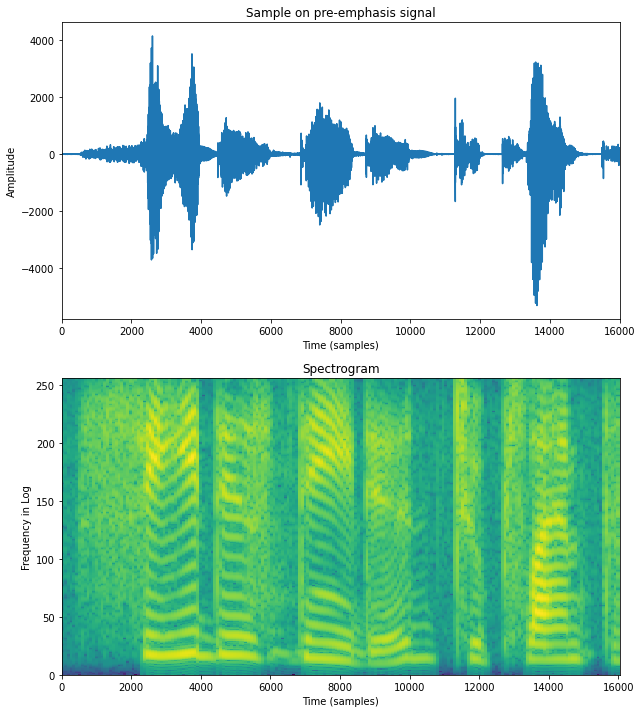

In [28]:
tf_stft = np.abs(tf_spectrum)
tf_stft_log = np.log(tf_stft.T + np.finfo(float).eps)
print(tf_stft_log.shape)

height = tf_stft_log.shape[0]  # frequency in log
width = tf_stft_log.shape[1]   # time peroid
X = np.linspace(0, len(pad_signal), num=width, dtype=int)
Y = range(height)

fig, ax = plt.subplots(2, 1, figsize=(10, 12))
ax[0].plot(audio_content)
ax[0].set_ylabel("Amplitude")
ax[0].set_xlabel("Time (samples)")
ax[0].set_title("Sample on pre-emphasis signal")
ax[0].set_xlim((0, 16000))

ax[1].pcolormesh(X, Y, tf_stft_log)
ax[1].set_title('Spectrogram')
ax[1].set_xlabel("Time (samples)")
ax[1].set_ylabel("Frequency in Log")
plt.show()

## Power Spectrum

Next, compute the power spectrum.

$$P=\frac{|FFT(x_i)|^2}{N}$$

where $x_i$ is the $i$-th of signal x.

In [49]:
pow_frames = (mag_frames ** 2.0) / nFFT
pow_frames.shape

(198, 257)

## Mel Specturm

### Mel Scale

$$Mel(f) = 2595*log_{10}{(1 + \frac{f}{700})}$$
$$f=700(10^{\frac{m}{2595}}-1)$$

Frequencies are important factors for human listening. However, the sensitivity of listening in different zones of frequencies is different. Humans are more sensitive to the changes of lower frequencies than the ones of higher frequencies. The Mel scale was purposed for that. 

In [50]:
def mel(f):
  return 2595 * np.log10(1+(f/700))

def hz(mel):
  return 700 * (10 ** (mel/2595) - 1)

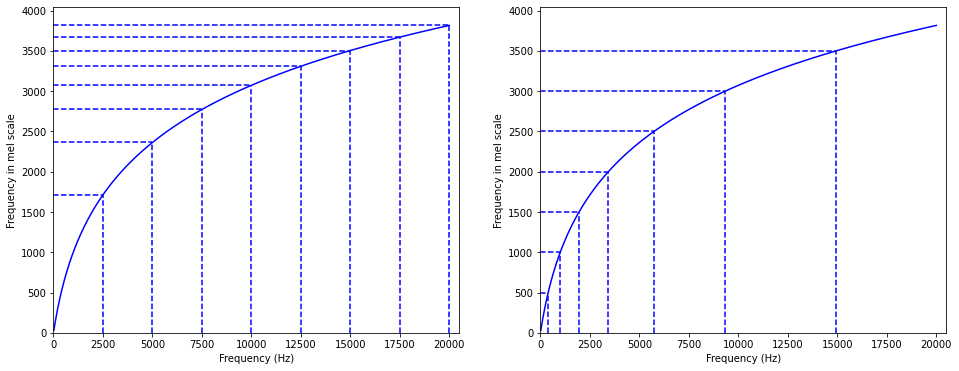

In [51]:
human_sound_hz = np.linspace(20, 20000, num=(20000-20+1))
human_sound_mel = [mel(f) for f in human_sound_hz]

fig, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].plot(human_sound_hz, human_sound_mel, '-b')
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_ylabel("Frequency in mel scale")
for x, y in zip(human_sound_hz, human_sound_mel):
  if x % 2500 == 0:
    ax[0].plot([x, x], [0, y], '--b')
    ax[0].plot([0, x], [y, y], '--b')
ax[0].set_xlim((0, 20500))
ax[0].set_ylim((0, 4050))

ax[1].plot(human_sound_hz, human_sound_mel, '-b')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Frequency in mel scale")
for n in range(1, 8):
  d_mel = np.array(human_sound_mel) - 500 * n
  d_mel_idx = np.argmin(np.abs(d_mel))
  x, y = human_sound_hz[d_mel_idx], human_sound_mel[d_mel_idx]
  ax[1].plot([x, x], [0, y], '--b')
  ax[1].plot([0, x], [y, y], '--b')
ax[1].set_xlim((0, 20500))
ax[1].set_ylim((0, 4050))
plt.show()

From the above two figures, it is obvious that:

1. Humans are more sensitive to the change of lower frequencies than of higher frequencies. 


### Mel-filter banks

A filter bank is a set of digital band pass filters either a input or summed output. Applying a filter bank can help focus on the signal itself instead of other signals, like noise, etc. In practice, choosing filter bank depends on the problem you want to solve, it can be ignored as well for some conditions. The following image is the concept.

![](https://upload.wikimedia.org/wikipedia/en/d/df/Multidimensional_M_channel_Filter_Banks.jpg)

After applying the `STFT` to the signal, we have no frequency resolution to Mel scaled. We need to round those frequencies to the nearset FFT bin. To convert the frequencies to fft bin numbers, we need to know the FFT size and the sample rate.

In [52]:
num_filter = 20
low_freq_mel = 0
high_freq_mel = mel(4000)
all_freq_mel = np.linspace(low_freq_mel, high_freq_mel, num=num_filter + 2)
all_freq = hz(all_freq_mel)

print("Frequency: {} - {}".format(all_freq[0], all_freq[-1]))
print("Frequency in Mel scaled: {} - {}".format(all_freq_mel[0], all_freq_mel[-1]))

Frequency: 0.0 - 3999.9999999999995
Frequency in Mel scaled: 0.0 - 2146.06452750619


After the convertion, the bin 22 corresponds to 4KHz with a 129 point FFT size.

In [53]:
bin = np.floor((nFFT + 1) * all_freq / audio_rate)

len(bin), "", bin, ""

(22,
 '',
 array([  0.,   4.,   8.,  14.,  19.,  25.,  32.,  39.,  47.,  56.,  66.,
         76.,  88., 101., 114., 130., 146., 164., 184., 206., 230., 256.]),
 '')

In [54]:
fbanks = np.zeros(shape=(num_filter, int(nFFT / 2) + 1))

for m in range(1, num_filter+1):
  f_m_minus = int(bin[m-1])
  f_m = int(bin[m])
  f_m_plus = int(bin[m+1])

  for k in range(f_m_minus, f_m):
    fbanks[m-1, k] = (k - f_m_minus) / (f_m - f_m_minus)
  for k in range(f_m, f_m_plus):
    fbanks[m-1, k] = (f_m_plus - k) / (f_m_plus - f_m)

fbanks.shape

(20, 257)

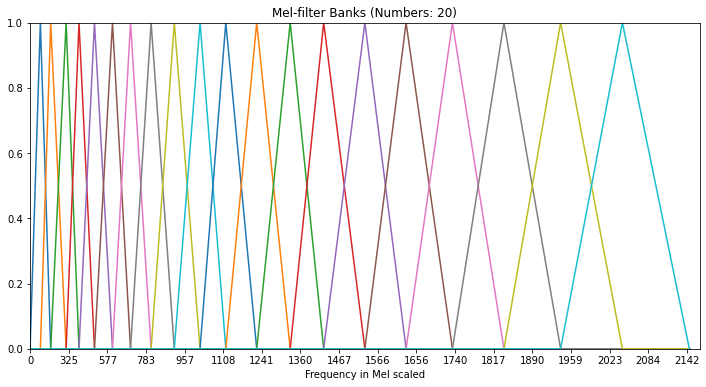

In [55]:
plt.figure(figsize=(12,6))

for fid in range(num_filter):
  plt.plot(fbanks[fid,:])

xticks = list(range(256))[::15]
ticklabels = mel(stft_freq[::15] * audio_rate).astype(np.int)
plt.xticks(xticks, ticklabels)

plt.xlabel("Frequency in Mel scaled")
plt.title("Mel-filter Banks (Numbers: {})".format(num_filter))
plt.xlim((0, 260))
plt.ylim((0, 1))
plt.show()

### Mel-frequency Cepstrum

In [57]:
# pow_frames: (time slices, feature dimensions)
# fbanks: (number of filters, filtering information)
pow_frames.shape, fbanks.shape

((198, 257), (20, 257))

In [69]:
mfc = np.dot(pow_frames, fbanks.T)
mfc = np.where(mfc == 0., np.finfo(float).eps, mfc)
mfc_log = 20 * np.log10(mfc)  # DB scaled

mfc.shape, mfc_log.shape

((198, 20), (198, 20))

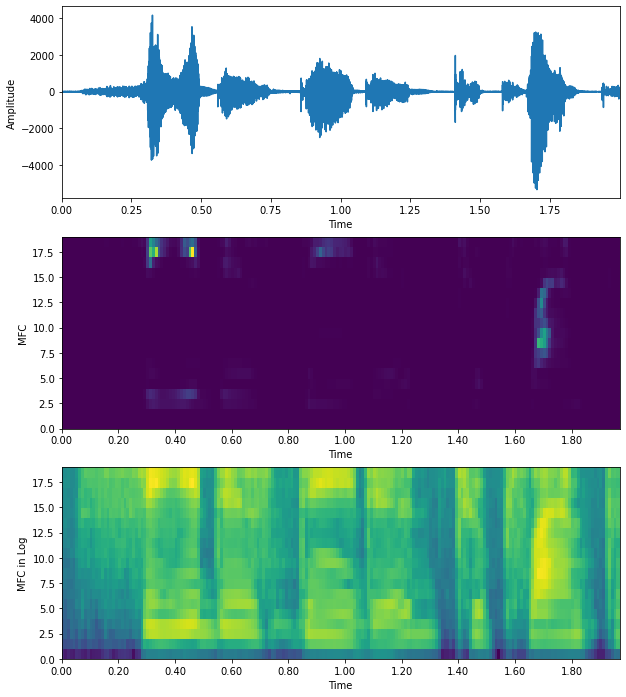

In [107]:
width = mfc.shape[0]
height = mfc.shape[1]

fig, ax = plt.subplots(3, 1, figsize=(10, 12))

xticks = list(range(len(audio_content)))[::2000]
ticklabels = list(np.linspace(0, 2, num=len(xticks) + 1))
ticklabels = ['{:.2f}'.format(item) for item in ticklabels]

ax[0].plot(audio_content)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Amplitude")
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(ticklabels)
ax[0].set_xlim((0, len(audio_content)))

xticks = list(range(width))[::20]
ticklabels = list(np.linspace(0, 2, num=len(xticks) + 1))
ticklabels = ['{:.2f}'.format(item) for item in ticklabels]

ax[1].pcolormesh(range(width), range(height), mfc.T)
ax[1].set_xlabel("Time")
ax[1].set_ylabel("MFC")
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(ticklabels)

ax[2].pcolormesh(range(width), range(height), mfc_log.T)
ax[2].set_xlabel("Time")
ax[2].set_ylabel("MFC in Log")
ax[2].set_xticks(xticks)
ax[2].set_xticklabels(ticklabels)
plt.show()

### Mel-frequency Cepstrum Coefficients (MFCC)

The Discrete Cosine Transform (DCT) is a conversion of extracting few important coefficients. You can imagine the DCT is like a compression approach. The DCT is also applied in JPEG compression. The basic idea behind DCT is to keep the determinic points around the boundaries.

DCT also helps de-correlate filter banks.

You can look up the detail description why `DCT` is important to the MFC by the issue (https://dsp.stackexchange.com/questions/31/how-do-i-interpret-the-dct-step-in-the-mfcc-extraction-process).

In [108]:
from scipy.fftpack import dct

In Automatic Speech Recognition (ASR), it is recommended to keep the number of cepstral coefficients between 2 and 13. The reason behind it is that more coefficients don't help a lot.

In [111]:
num_ceps = 12

In [112]:
mfcc = dct(x=mfc, type=2, axis=1, norm='ortho')[:, 1:num_ceps+1]
mfcc.shape

(198, 12)

### De-lifting or De-emphasis (Optional)

You can also apply the sinusoid lifting to MFCCs to de-emphasis the higher MFCCs to improve the speech signals in noisy signals.


In [117]:
num_frames, num_coef = mfcc.shape
n_coef = 12
n = np.arange(num_coef)
lifting = 1 + (n_coef / 2) * np.sin(np.pi * n / n_coef)
lifting.shape, lifting

((12,), array([1.        , 2.55291427, 4.        , 5.24264069, 6.19615242,
        6.79555496, 7.        , 6.79555496, 6.19615242, 5.24264069,
        4.        , 2.55291427]))

In [118]:
lifting_mfcc = mfcc * lifting
lifting_mfcc.shape

(198, 12)

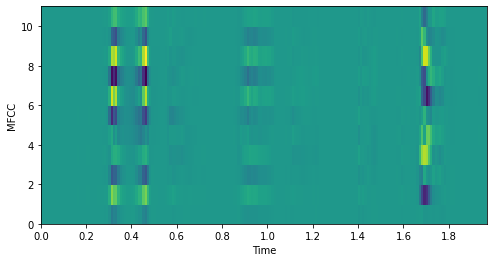

In [125]:
width, height = lifting_mfcc.shape

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

xticks = list(range(width))[::20]
ticklabels = list(np.linspace(0, 2, num=len(xticks) + 1))
ticklabels = ['{:.1f}'.format(item) for item in ticklabels]

ax.pcolormesh(
  list(range(width)),
  list(range(height)),
  lifting_mfcc.T
)
ax.set_xlabel("Time")
ax.set_ylabel("MFCC")
ax.set_xticks(xticks)
ax.set_xticklabels(ticklabels)

plt.show()

## Mean Normalization

In order to balance the spectrum and improve the signal-to-noise ratio (SNR), we can simply subtract the mean value. This operation can be applied in filter banks or MFCCs.

### Filter banks

In [127]:
fbanks.shape

(20, 257)

In [130]:
nor_fbanks = fbanks - np.mean(fbanks, axis=0) + 1e-8
nor_fbanks.shape

(20, 257)

### MFCCs

In [131]:
nor_mfccs = mfcc - np.mean(mfcc, axis=0) + 1e-8
nor_mfccs.shape

(198, 12)

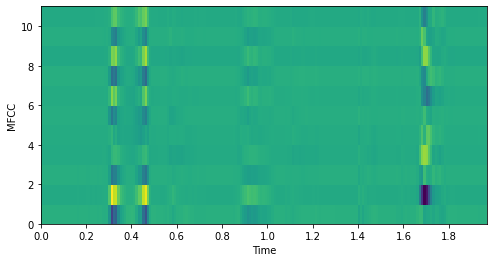

In [132]:
width, height = nor_mfccs.shape

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

xticks = list(range(width))[::20]
ticklabels = list(np.linspace(0, 2, num=len(xticks) + 1))
ticklabels = ['{:.1f}'.format(item) for item in ticklabels]

ax.pcolormesh(
  list(range(width)),
  list(range(height)),
  nor_mfccs.T
)
ax.set_xlabel("Time")
ax.set_ylabel("MFCC")
ax.set_xticks(xticks)
ax.set_xticklabels(ticklabels)

plt.show()